# Tarea: ExperimentaciÃ³n con Redes Neuronales Feed-Forward (MLP)
## curso machine learning(introducciÃ³n a deep learning)

**Objetivo**: Explorar cÃ³mo diferentes hiperparÃ¡metros y arquitecturas afectan el desempeÃ±o de una red neuronal multicapa en el problema de clasificaciÃ³n de dÃ­gitos manuscritos (MNIST). Se usan los siguientes conceptos que aÃºn no hemos visto en clase pero que son fÃ¡ciles de interpretar:

* test-set: Datos que el modelo no ha recibido como entrada en su entrenamiento, son datos nunca antes vistos por lel modelo por lo que usarlos nos da una idea de como se comportarÃ¡ el modelo al ser usado para realizar predicciones en datos nuevos.
* underfitting: problema de calidad del modelo en el cual este no realiza predicciones correctas ni en los datos en los que se entrenÃ³, ni en datos nuevos, es un modelo de baja calidad(puede ocurrir por entrenarse muy pocas iteraciones, por usar pocas capas, por usar pocas neuronas por capa etc). Se detecta por que las mÃ©tricas de calidad como accurracy son muy bajas, o se tiene un error/costo/perdida muy alto tanto en los datos de entrenamiento como en los de test.
* overfitting: problema de calidad del modelo en el cual este realiza predicciones correctas en el set(datos) de entrenamiento pero al probarlo en nuevos datos nunca usados(test-set) este no genera buenas predicciones, se dice que el modelo "memorizÃ³" en lugar de aprender y es capaz de "generalizar". Puede ocurrir por: tener muy pocos datos ,entrenarlo por muchas iteraciones(mÃ¡s de lo necesario), o una arquitectura muy compleja(muchas capas o muchas neuronas por capa). Se detecta por que las mÃ©tricas de calidad como accurracy son altas en el set de entrenamiento, pero bajas en el test set o bien se tiene que el error/cost/loss es bajo en el set de entrenamiento pero alto en el test set.
* Dropout: tÃ©cnica que ayuda a reducir el riesgo de overfitting a travÃ©s de modificar la arquitectura de la red de forma que durante el entrenamiento algunas neuronas estÃ¡n desactivadas.
* Batch normalization: tÃ©cnica que ayuda a estabilizar el entrenamiento, hacer que se converja mas rÃ¡pido y tambiÃ©n puede ayudar a reducir el overfitting en algunos casos, se basa en aplicar algunas transformaciones estadÃ­sticas a los datos de las capas intermedias/ocultas.

---

## Instrucciones Generales

En esta tarea trabajarÃ¡s con el dataset MNIST y una arquitectura de red neuronal feed-forward (Multi-Layer Perceptron). El cÃ³digo base ya estÃ¡ implementado, tu trabajo consistirÃ¡ en:

1. Ejecutar 10 experimentos modificando diferentes aspectos de la red
2. Analizar los resultados de cada experimento
3. Responder las preguntas especÃ­ficas de cada ejercicio

**Entrega**: Completa todos los ejercicios en este notebook, ejecuta las celdas correspondientes, y responde las preguntas en las celdas de markdown proporcionadas.

---
## ConfiguraciÃ³n Inicial y CÃ³digo Base

In [12]:
# Imports necesarios
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from time import time
from datetime import datetime
# ConfiguraciÃ³n para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

# Verificar disponibilidad de GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cpu


In [ ]:
# Cargar el dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # NormalizaciÃ³n estÃ¡ndar para MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f'TamaÃ±o del conjunto de entrenamiento: {len(train_dataset)}')
print(f'TamaÃ±o del conjunto de prueba: {len(test_dataset)}')

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.77MB/s]

TamaÃ±o del conjunto de entrenamiento: 60000
TamaÃ±o del conjunto de prueba: 10000


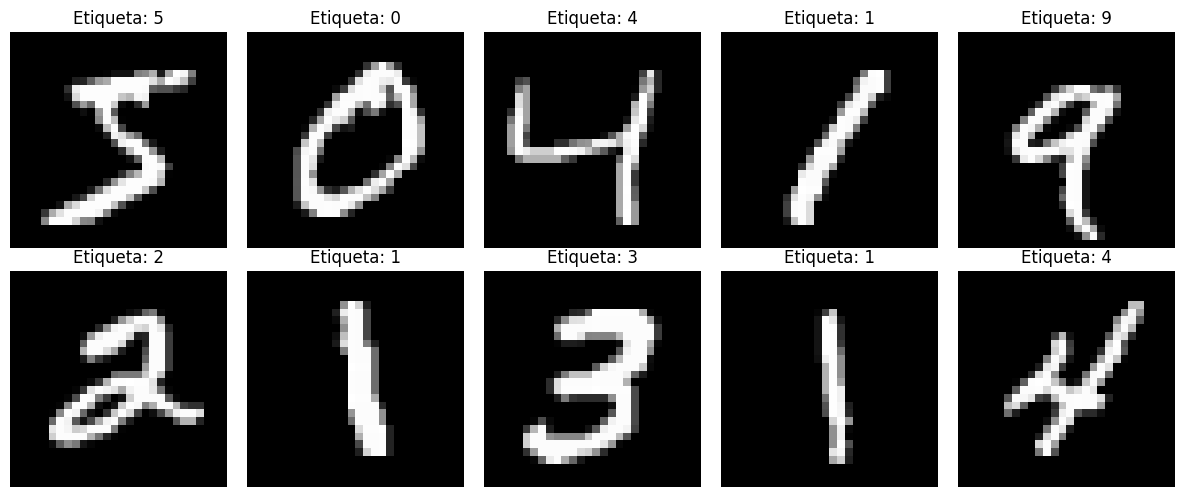

In [ ]:
# Visualizar algunos ejemplos del dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Etiqueta: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### DefiniciÃ³n de la Red Neuronal Feed-Forward (MLP)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128, 64], output_size=10,
                 activation='relu', use_dropout=False, dropout_rate=0.5, use_batch_norm=False):
        """
        Multi-Layer Perceptron (MLP) flexible.

        Args:
            input_size: TamaÃ±o de la entrada (28*28=784 para MNIST)
            hidden_sizes: Lista con el nÃºmero de neuronas en cada capa oculta
            output_size: NÃºmero de clases (10 para MNIST)
            activation: FunciÃ³n de activaciÃ³n ('relu', 'tanh', 'sigmoid')
            use_dropout: Si se debe usar dropout
            dropout_rate: Tasa de dropout
            use_batch_norm: Si se debe usar batch normalization
        """
        super(MLP, self).__init__()

        # Seleccionar funciÃ³n de activaciÃ³n
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError(f'ActivaciÃ³n no soportada: {activation}')

        # Construir capas
        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))

            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))

            layers.append(self.activation)

            if use_dropout:
                layers.append(nn.Dropout(dropout_rate))

            prev_size = hidden_size

        # Capa de salida
        layers.append(nn.Linear(prev_size, output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # Aplanar la imagen de 28x28 a un vector de 784
        x = x.view(x.size(0), -1)
        return self.network(x)

print('Arquitectura MLP definida correctamente')

Arquitectura MLP definida correctamente


### Funciones de Entrenamiento y EvaluaciÃ³n

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device):
    """
    Entrena el modelo por una Ã©poca.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass y optimizaciÃ³n
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # EstadÃ­sticas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc


def evaluate_model(model, test_loader, criterion, device):
    """
    EvalÃºa el modelo en el conjunto de prueba.
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total

    return test_loss, test_acc


def run_experiment(model, train_loader, test_loader, criterion, optimizer,
                   epochs, device, experiment_name="Experimento"):
    """
    Ejecuta un experimento completo de entrenamiento y evaluaciÃ³n.
    """
    print(f"\n{'='*60}")
    print(f"{experiment_name}")
    print(f"{'='*60}\n")

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    start_time = time()

    for epoch in range(epochs):
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if (epoch + 1) % 2 == 0 or epoch == 0:
            print(f'Ã‰poca [{epoch+1}/{epochs}] - '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - '
                  f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    training_time = time() - start_time

    print(f"\nTiempo total de entrenamiento: {training_time:.2f} segundos")
    print(f"PrecisiÃ³n final en test: {test_accs[-1]:.2f}%")

    # Graficar resultados
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(test_losses, label='Test Loss', marker='s')
    ax1.set_xlabel('Ã‰poca')
    ax1.set_ylabel('Loss')
    ax1.set_title('PÃ©rdida durante el Entrenamiento')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(train_accs, label='Train Accuracy', marker='o')
    ax2.plot(test_accs, label='Test Accuracy', marker='s')
    ax2.set_xlabel('Ã‰poca')
    ax2.set_ylabel('PrecisiÃ³n (%)')
    ax2.set_title('PrecisiÃ³n durante el Entrenamiento')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'final_test_acc': test_accs[-1],
        'training_time': training_time
    }

print('Funciones de entrenamiento y evaluaciÃ³n definidas correctamente')

Funciones de entrenamiento y evaluaciÃ³n definidas correctamente


---
---
# EJERCICIOS

A continuaciÃ³n se presentan 10 ejercicios donde deberÃ¡s modificar diferentes aspectos del modelo y analizar los resultados.

---
## Ejercicio 1: Modelo Baseline

**Objetivo**: Entrenar un modelo base con hiperparÃ¡metros estÃ¡ndar para establecer una lÃ­nea de referencia.

**ConfiguraciÃ³n**:
- Arquitectura: [128, 64] (2 capas ocultas)
- Learning rate: 0.001
- Batch size: 64
- Ã‰pocas: 10
- ActivaciÃ³n: ReLU
- Optimizador: Adam


Ejercicio 1: Modelo Baseline

Ã‰poca [1/10] - Train Loss: 0.2688, Train Acc: 91.93% - Test Loss: 0.1396, Test Acc: 95.68%
Ã‰poca [2/10] - Train Loss: 0.1125, Train Acc: 96.57% - Test Loss: 0.1005, Test Acc: 96.94%
Ã‰poca [4/10] - Train Loss: 0.0611, Train Acc: 97.99% - Test Loss: 0.0846, Test Acc: 97.28%
Ã‰poca [6/10] - Train Loss: 0.0408, Train Acc: 98.58% - Test Loss: 0.0820, Test Acc: 97.45%
Ã‰poca [8/10] - Train Loss: 0.0292, Train Acc: 99.01% - Test Loss: 0.0996, Test Acc: 97.41%
Ã‰poca [10/10] - Train Loss: 0.0234, Train Acc: 99.20% - Test Loss: 0.0892, Test Acc: 97.66%

Tiempo total de entrenamiento: 202.98 segundos
PrecisiÃ³n final en test: 97.66%


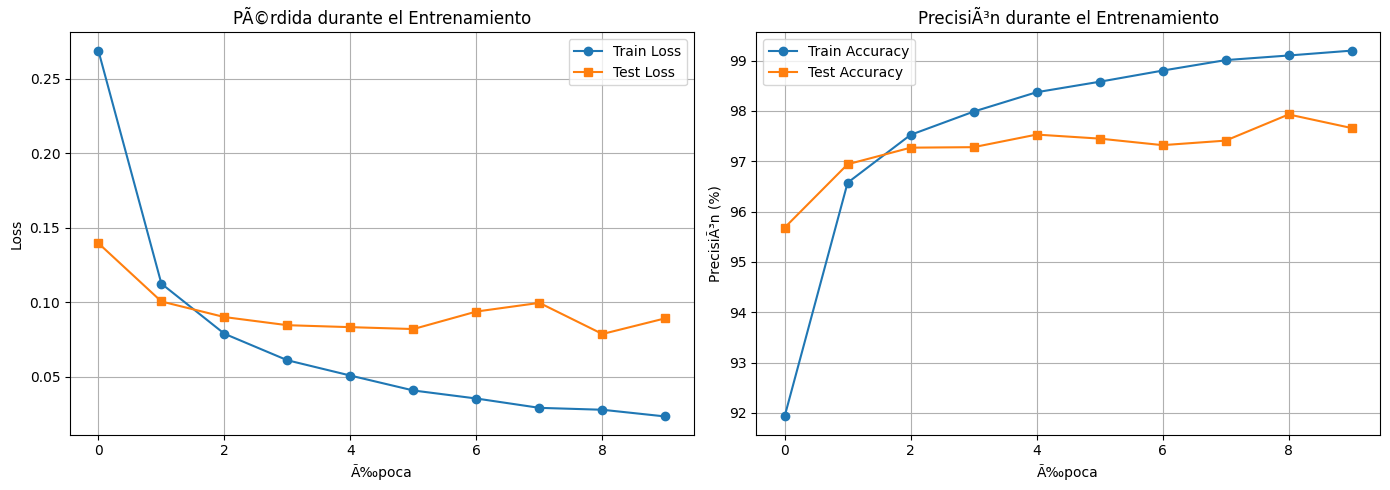

Tiempo de entrenamiento: 0:03:23.339060


In [15]:
# ConfiguraciÃ³n del Ejercicio 1
batch_size = 64
learning_rate = 0.001
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[128, 64], activation='relu').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

before1 = datetime.now()
results_ex1 = run_experiment(model, train_loader, test_loader, criterion, optimizer,
                             epochs, device, "Ejercicio 1: Modelo Baseline")
after1 = datetime.now()
time_spent1 = after1 - before1
print(f'Tiempo de entrenamiento: {time_spent1}')

### Respuestas Ejercicio 1

**1.1** Â¿CuÃ¡l fue la precisiÃ³n final en el conjunto de test?

97.66%

**1.2** Â¿Observas signos de overfitting o underfitting? Justifica tu respuesta basÃ¡ndote en las grÃ¡ficas.

Creo que no, presenta ninguno de los problemas mencionandos.

Con respecto al overfitting, en efecto existe una diferencia entre los resultados de la data de entrenamiento con la data de testing, pero creo que la diferencia observada aun se puede llegar a tomar como una diferencia normal, que no quiere decir que el modelo este mal funcionando.

Por otro lado, hablando de underfittint, creo que los resultados obtenidos son bastante buenos como para pensar que el modelo no esta categorizando bien los elementos.

---
## Ejercicio 2: Efecto del Learning Rate

**Objetivo**: Experimentar con un learning rate mÃ¡s alto (0.01) y analizar cÃ³mo afecta la convergencia.

**ModificaciÃ³n**: Cambia el learning rate de 0.001 a 0.01

**Pregunta**: Â¿CÃ³mo afecta un learning rate mÃ¡s alto al entrenamiento? Â¿Es mejor o peor que el baseline?


Ejercicio 2: Learning Rate Alto (0.01)

Ã‰poca [1/10] - Train Loss: 0.2805, Train Acc: 91.63% - Test Loss: 0.2144, Test Acc: 94.64%
Ã‰poca [2/10] - Train Loss: 0.1924, Train Acc: 94.86% - Test Loss: 0.1794, Test Acc: 95.33%
Ã‰poca [4/10] - Train Loss: 0.1497, Train Acc: 95.99% - Test Loss: 0.2236, Test Acc: 94.92%
Ã‰poca [6/10] - Train Loss: 0.1450, Train Acc: 96.33% - Test Loss: 0.1597, Test Acc: 96.18%
Ã‰poca [8/10] - Train Loss: 0.1256, Train Acc: 96.90% - Test Loss: 0.1895, Test Acc: 96.06%
Ã‰poca [10/10] - Train Loss: 0.1200, Train Acc: 97.14% - Test Loss: 0.1909, Test Acc: 96.52%

Tiempo total de entrenamiento: 202.80 segundos
PrecisiÃ³n final en test: 96.52%


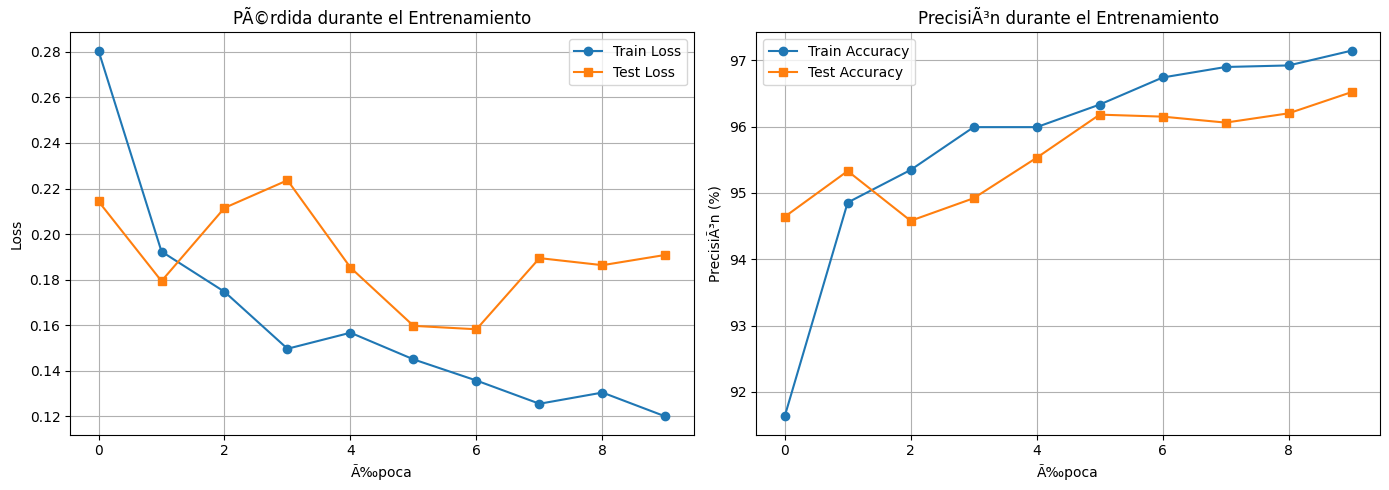

In [10]:
# ConfiguraciÃ³n del Ejercicio 2
batch_size = 64
learning_rate = 0.01  # MODIFICADO
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[128, 64], activation='relu').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results_ex2 = run_experiment(model, train_loader, test_loader, criterion, optimizer,
                             epochs, device, "Ejercicio 2: Learning Rate Alto (0.01)")

### Respuestas Ejercicio 2

**2.1** Compara la precisiÃ³n final con el Ejercicio 1. Â¿MejorÃ³ o empeorÃ³?

Bajo ligeramente, de 97.66% a 96.52%.

**2.2** Â¿CÃ³mo se ve la curva de loss? Â¿Es mÃ¡s estable o mÃ¡s inestable que en el baseline?

Es mas inestable con este learning rate. Otra observacion, es que tanto el train loss como el test loss aumentarion al haber incrementado el learning rate.

**2.3** Â¿QuÃ© puedes concluir sobre la elecciÃ³n del learning rate?

Que es demasiado alto, se deberia, al menos, regresar al valor anterior, dado a que mostraba datos mas estables.

---
## Ejercicio 3: Red mÃ¡s Profunda

**Objetivo**: Aumentar la profundidad de la red agregando mÃ¡s capas ocultas.

**ModificaciÃ³n**: Cambia la arquitectura de [128, 64] a [256, 128, 64, 32]

**Pregunta**: Â¿Una red mÃ¡s profunda siempre es mejor? Â¿QuÃ© observas en tÃ©rminos de tiempo de entrenamiento y precisiÃ³n?


Ejercicio 3: Red MÃ¡s Profunda [256, 128, 64, 32]

Ã‰poca [1/10] - Train Loss: 0.2936, Train Acc: 90.84% - Test Loss: 0.1231, Test Acc: 96.11%
Ã‰poca [2/10] - Train Loss: 0.1098, Train Acc: 96.63% - Test Loss: 0.1038, Test Acc: 96.85%
Ã‰poca [4/10] - Train Loss: 0.0607, Train Acc: 98.10% - Test Loss: 0.0856, Test Acc: 97.36%
Ã‰poca [6/10] - Train Loss: 0.0405, Train Acc: 98.71% - Test Loss: 0.0827, Test Acc: 97.74%
Ã‰poca [8/10] - Train Loss: 0.0305, Train Acc: 99.04% - Test Loss: 0.0768, Test Acc: 97.95%
Ã‰poca [10/10] - Train Loss: 0.0239, Train Acc: 99.27% - Test Loss: 0.0835, Test Acc: 97.91%

Tiempo total de entrenamiento: 229.48 segundos
PrecisiÃ³n final en test: 97.91%


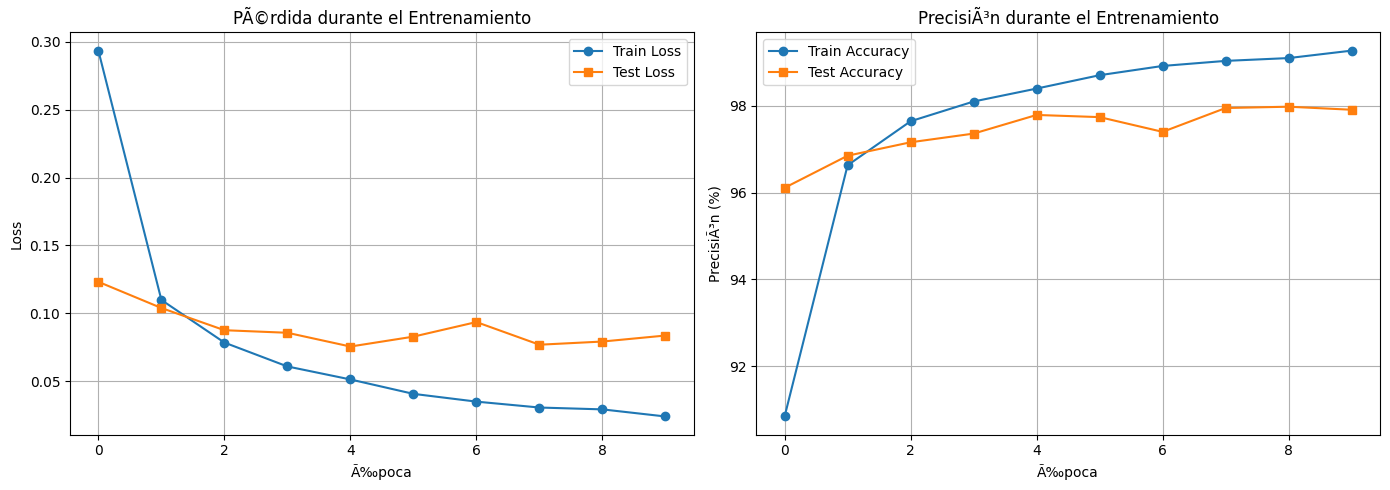

Tiempo de entrenamiento: 0:03:49.975556
Deferncia entre baseline: -1 day, 23:59:33.363504


In [16]:
# ConfiguraciÃ³n del Ejercicio 3
batch_size = 64
learning_rate = 0.001
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[256, 128, 64, 32], activation='relu').to(device)  # MODIFICADO
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

before3 = datetime.now()
results_ex3 = run_experiment(model, train_loader, test_loader, criterion, optimizer,
                             epochs, device, "Ejercicio 3: Red MÃ¡s Profunda [256, 128, 64, 32]")
after3 = datetime.now()
time_spent3 = after3 - before3
print(f'Tiempo de entrenamiento: {time_spent3}')
print(f'Deferncia entre baseline: {time_spent1 - time_spent3}')

### Respuestas Ejercicio 3

**3.1** Â¿MejorÃ³ la precisiÃ³n en test comparado con el baseline?

Si, en efecto mejora de 97.66% a 97.91%.

**3.2** Â¿CuÃ¡nto mÃ¡s tiempo tomÃ³ entrenar este modelo?

es 113% el tiempo de ejecucion. Como comentario, pense que iba a ser bastante mas tiempo.

**3.3** Â¿Vale la pena el costo computacional adicional? Justifica.

No lo creo, realmente el porcentaje de mejora fue de 0.25%, lo cual no lo veo muy util para segurmanete el pode computacional agregado de las redes ocultas.

---
## Ejercicio 4: Batch Size PequeÃ±o

**Objetivo**: Experimentar con un batch size mÃ¡s pequeÃ±o y observar el efecto en el entrenamiento.

**ModificaciÃ³n**: Cambia el batch size de 64 a 16

**Pregunta**: Â¿CÃ³mo afecta el tamaÃ±o del batch al proceso de entrenamiento y a la convergencia?


Ejercicio 4: Batch Size PequeÃ±o (16)

Ã‰poca [1/10] - Train Loss: 0.2219, Train Acc: 93.18% - Test Loss: 0.1176, Test Acc: 96.26%
Ã‰poca [2/10] - Train Loss: 0.1044, Train Acc: 96.82% - Test Loss: 0.1061, Test Acc: 96.81%
Ã‰poca [4/10] - Train Loss: 0.0639, Train Acc: 98.01% - Test Loss: 0.0865, Test Acc: 97.44%
Ã‰poca [6/10] - Train Loss: 0.0477, Train Acc: 98.50% - Test Loss: 0.0845, Test Acc: 97.86%
Ã‰poca [8/10] - Train Loss: 0.0387, Train Acc: 98.85% - Test Loss: 0.0967, Test Acc: 97.68%
Ã‰poca [10/10] - Train Loss: 0.0326, Train Acc: 99.02% - Test Loss: 0.1098, Test Acc: 97.66%

Tiempo total de entrenamiento: 292.22 segundos
PrecisiÃ³n final en test: 97.66%


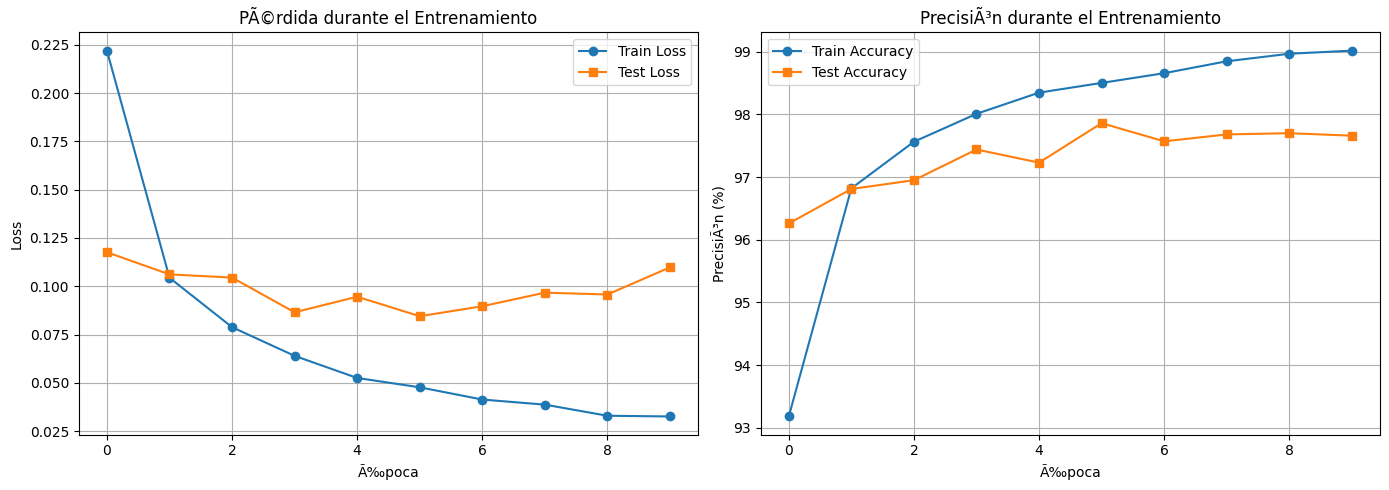

In [17]:
# ConfiguraciÃ³n del Ejercicio 4
batch_size = 16  # MODIFICADO
learning_rate = 0.001
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[128, 64], activation='relu').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results_ex4 = run_experiment(model, train_loader, test_loader, criterion, optimizer,
                             epochs, device, "Ejercicio 4: Batch Size PequeÃ±o (16)")

### Respuestas Ejercicio 4

**4.1** Â¿CÃ³mo se compara el tiempo de entrenamiento con el baseline?

es 144% el tiempo de ejecucion. lo cual indica que para este caso si hay un aumento considerable.

**4.2** Â¿Las curvas de loss son mÃ¡s suaves o mÃ¡s ruidosas?

Creo que son mas ruidosas, no hay tanto cambio pero si son levemente mas ruidosas.

**4.3** Â¿CuÃ¡l es el trade-off entre batch size pequeÃ±o y grande?

la precicion se mantuvo en 97.66%, pero tengo entendido que de esta forma pudimos mejorar el uso de recursos, no necesitamos tantos recursos computacionales como en batch_sizes mas grandes.

---
## Ejercicio 5: FunciÃ³n de ActivaciÃ³n Tanh

**Objetivo**: Explorar el efecto de usar una funciÃ³n de activaciÃ³n diferente.

**ModificaciÃ³n**: Cambia la funciÃ³n de activaciÃ³n de ReLU a Tanh

**Pregunta**: Â¿CÃ³mo se desempeÃ±a Tanh comparado con ReLU para este problema?


Ejercicio 5: ActivaciÃ³n Tanh

Ã‰poca [1/10] - Train Loss: 0.2769, Train Acc: 92.46% - Test Loss: 0.1493, Test Acc: 95.49%
Ã‰poca [2/10] - Train Loss: 0.1158, Train Acc: 96.50% - Test Loss: 0.1047, Test Acc: 96.79%
Ã‰poca [4/10] - Train Loss: 0.0659, Train Acc: 97.94% - Test Loss: 0.1040, Test Acc: 96.91%
Ã‰poca [6/10] - Train Loss: 0.0503, Train Acc: 98.36% - Test Loss: 0.0917, Test Acc: 97.29%
Ã‰poca [8/10] - Train Loss: 0.0374, Train Acc: 98.75% - Test Loss: 0.1006, Test Acc: 97.34%
Ã‰poca [10/10] - Train Loss: 0.0300, Train Acc: 98.98% - Test Loss: 0.0966, Test Acc: 97.25%

Tiempo total de entrenamiento: 198.99 segundos
PrecisiÃ³n final en test: 97.25%


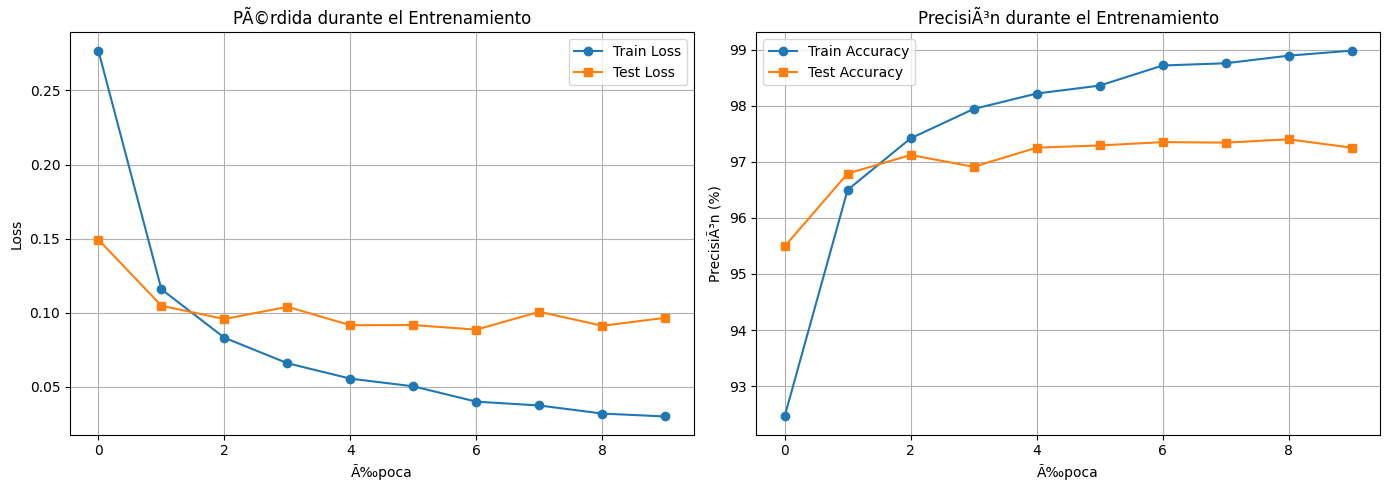

In [18]:
# ConfiguraciÃ³n del Ejercicio 5
batch_size = 64
learning_rate = 0.001
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[128, 64], activation='tanh').to(device)  # MODIFICADO
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results_ex5 = run_experiment(model, train_loader, test_loader, criterion, optimizer,
                             epochs, device, "Ejercicio 5: ActivaciÃ³n Tanh")

### Respuestas Ejercicio 5

**5.1** Compara la precisiÃ³n final con el baseline (ReLU).

La precision de 97.66% a 97.25%, lo cual creo que es irrelevante, creo que, para esste caso, ambas funciones pueden dar resultados muy similares.

**5.2** Â¿QuÃ© diferencias notas en la velocidad de convergencia?

El proceso fue ligeramente mas corto, el cual fueron aproximadamente 2 segundos menos.

**5.3** Â¿Por quÃ© crees que ReLU es mÃ¡s popular en deep learning moderno?

Tengo entendido que es mas barata en recursos computacionales, por lo que sera en muchas ocasiones por su eficiencia.

---
## Ejercicio 6: Agregar Dropout

**Objetivo**: Implementar regularizaciÃ³n con Dropout para prevenir overfitting.

**ModificaciÃ³n**: Activa dropout con tasa de 0.5

**Pregunta**: Â¿CÃ³mo ayuda el dropout a mejorar la generalizaciÃ³n del modelo?


Ejercicio 6: Con Dropout (0.5)

Ã‰poca [1/10] - Train Loss: 0.5652, Train Acc: 82.82% - Test Loss: 0.2023, Test Acc: 93.83%
Ã‰poca [2/10] - Train Loss: 0.3230, Train Acc: 90.91% - Test Loss: 0.1640, Test Acc: 95.03%
Ã‰poca [4/10] - Train Loss: 0.2511, Train Acc: 92.76% - Test Loss: 0.1252, Test Acc: 96.18%
Ã‰poca [6/10] - Train Loss: 0.2296, Train Acc: 93.50% - Test Loss: 0.1173, Test Acc: 96.59%
Ã‰poca [8/10] - Train Loss: 0.2102, Train Acc: 93.95% - Test Loss: 0.1126, Test Acc: 96.60%
Ã‰poca [10/10] - Train Loss: 0.1983, Train Acc: 94.30% - Test Loss: 0.0994, Test Acc: 97.12%

Tiempo total de entrenamiento: 204.74 segundos
PrecisiÃ³n final en test: 97.12%


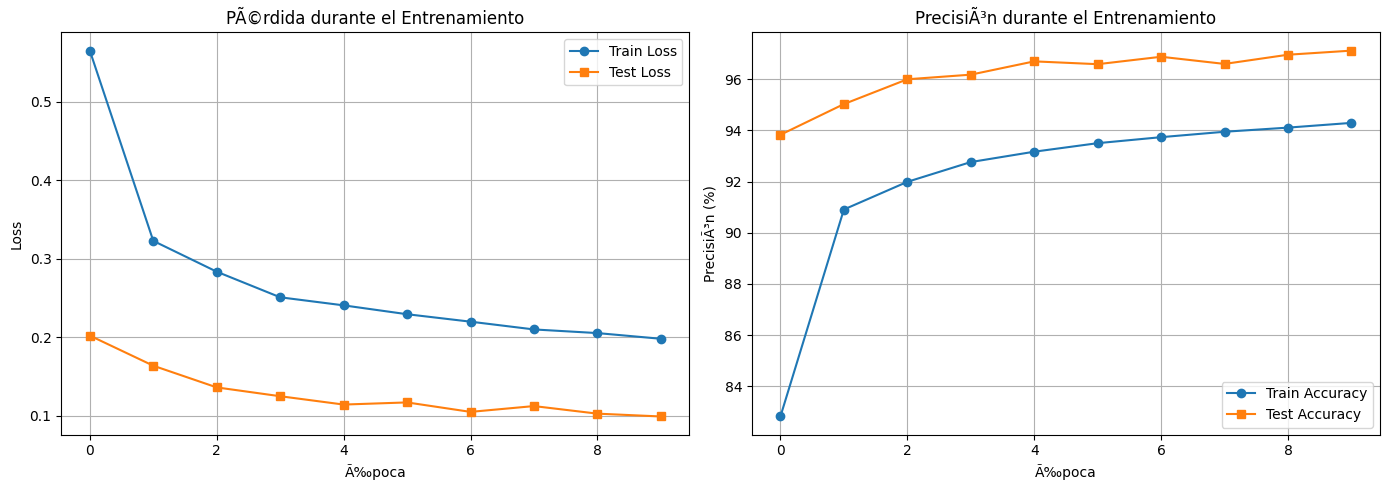

In [19]:
# ConfiguraciÃ³n del Ejercicio 6
batch_size = 64
learning_rate = 0.001
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[128, 64], activation='relu',
            use_dropout=True, dropout_rate=0.5).to(device)  # MODIFICADO
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results_ex6 = run_experiment(model, train_loader, test_loader, criterion, optimizer,
                             epochs, device, "Ejercicio 6: Con Dropout (0.5)")

### Respuestas Ejercicio 6

**6.1** Â¿La brecha entre train accuracy y test accuracy se redujo?

Realmente no, esta se aumentó, en el baseline se tenia una brecha de 1.54, pero en este test se tiene una diferencia de 2.82.

**6.2** Â¿CÃ³mo afectÃ³ el dropout a la precisiÃ³n en training?

Es curioso, utilzar droput el resultante fue que el train loss ahora es mayor con respecto al test loss. El comportamiento de los anteriores casos habian que siempre el test loss era mayor comparado con el train.

Esto tambien se repite en la precision.

**6.3** Â¿En quÃ© situaciones recomendarÃ­as usar dropout?

En redes densas es recomndable usarlo. Tambien se puede usar cuando los valores de trainnig bajan mucho y los de testing dejan de subir.

---
## Ejercicio 7: Batch Normalization

**Objetivo**: Explorar el efecto de Batch Normalization en la estabilidad y velocidad del entrenamiento.

**ModificaciÃ³n**: Activa batch normalization

**Pregunta**: Â¿CÃ³mo mejora Batch Normalization el proceso de entrenamiento?


Ejercicio 7: Con Batch Normalization

Ã‰poca [1/10] - Train Loss: 0.2563, Train Acc: 93.48% - Test Loss: 0.0953, Test Acc: 97.09%
Ã‰poca [2/10] - Train Loss: 0.0935, Train Acc: 97.14% - Test Loss: 0.0785, Test Acc: 97.55%
Ã‰poca [4/10] - Train Loss: 0.0563, Train Acc: 98.19% - Test Loss: 0.0680, Test Acc: 97.98%
Ã‰poca [6/10] - Train Loss: 0.0366, Train Acc: 98.81% - Test Loss: 0.0651, Test Acc: 98.02%
Ã‰poca [8/10] - Train Loss: 0.0275, Train Acc: 99.05% - Test Loss: 0.0702, Test Acc: 97.98%
Ã‰poca [10/10] - Train Loss: 0.0228, Train Acc: 99.23% - Test Loss: 0.0719, Test Acc: 97.91%

Tiempo total de entrenamiento: 203.82 segundos
PrecisiÃ³n final en test: 97.91%


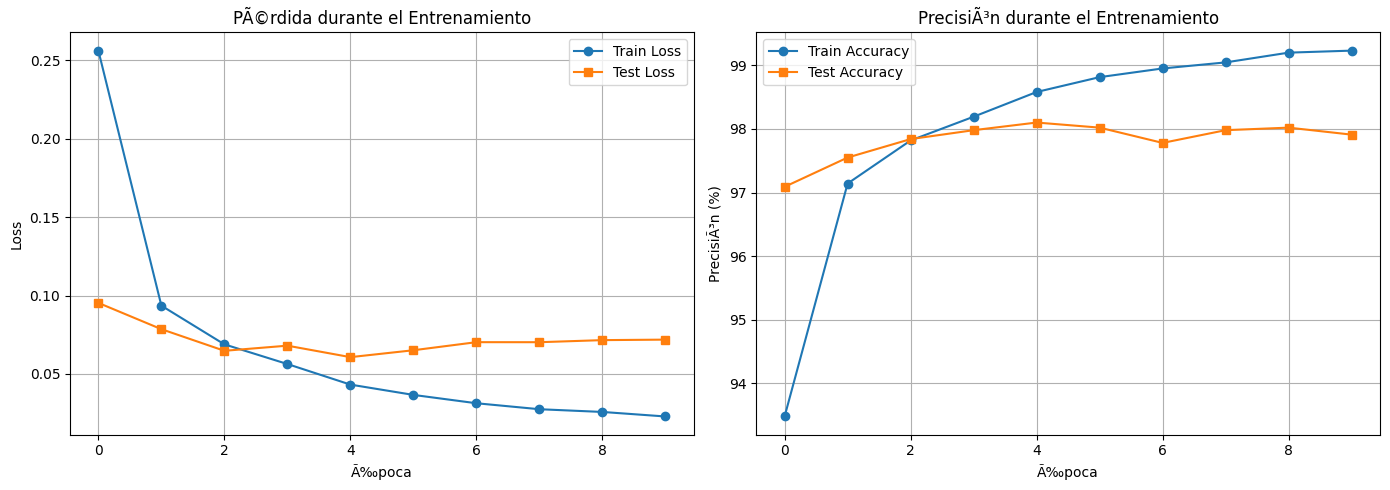

In [20]:
# ConfiguraciÃ³n del Ejercicio 7
batch_size = 64
learning_rate = 0.001
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[128, 64], activation='relu',
            use_batch_norm=True).to(device)  # MODIFICADO
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results_ex7 = run_experiment(model, train_loader, test_loader, criterion, optimizer,
                             epochs, device, "Ejercicio 7: Con Batch Normalization")

### Respuestas Ejercicio 7

**7.1** Â¿Observas una convergencia mÃ¡s rÃ¡pida con Batch Normalization?

Si, se observa una ligera convergencia más rápida. Esto mas notable al inicio del entranamiento.

**7.2** Â¿MejorÃ³ la precisiÃ³n final comparada con el baseline?

Si, mejora de 97.66% a un 97.91% (el mejor resultado hasta ahora)

**7.3** Â¿CuÃ¡l es el principal beneficio de usar Batch Normalization?

*Tu respuesta aquÃ­*

---
## Ejercicio 8: Red MÃ¡s Ancha

**Objetivo**: Experimentar con una arquitectura mÃ¡s ancha en lugar de mÃ¡s profunda.

**ModificaciÃ³n**: Cambia la arquitectura de [128, 64] a [512, 256]

**Pregunta**: Â¿Es mejor tener una red ancha o una red profunda? Â¿Por quÃ©?

In [ ]:
# ConfiguraciÃ³n del Ejercicio 8
batch_size = 64
learning_rate = 0.001
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[512, 256], activation='relu').to(device)  # MODIFICADO
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results_ex8 = run_experiment(model, train_loader, test_loader, criterion, optimizer,
                             epochs, device, "Ejercicio 8: Red MÃ¡s Ancha [512, 256]")

### Respuestas Ejercicio 8

**8.1** Compara los resultados con el Ejercicio 3 (red mÃ¡s profunda).

*Tu respuesta aquÃ­*

**8.2** Â¿CuÃ¡l tiene mejor desempeÃ±o: red ancha o red profunda?

*Tu respuesta aquÃ­*

**8.3** Â¿QuÃ© principio puedes extraer sobre el diseÃ±o de arquitecturas?

*Tu respuesta aquÃ­*

---
## Ejercicio 9: Optimizador SGD

**Objetivo**: Comparar el optimizador Adam con SGD (Stochastic Gradient Descent).

**ModificaciÃ³n**: Cambia el optimizador de Adam a SGD con momentum=0.9

**Pregunta**: Â¿CuÃ¡les son las diferencias prÃ¡cticas entre Adam y SGD?

In [ ]:
# ConfiguraciÃ³n del Ejercicio 9
batch_size = 64
learning_rate = 0.01  # SGD tÃ­picamente requiere un learning rate mÃ¡s alto
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[128, 64], activation='relu').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # MODIFICADO

results_ex9 = run_experiment(model, train_loader, test_loader, criterion, optimizer,
                             epochs, device, "Ejercicio 9: Optimizador SGD con Momentum")

### Respuestas Ejercicio 9

**9.1** Â¿CÃ³mo se compara la precisiÃ³n final con el baseline (Adam)?

*Tu respuesta aquÃ­*

**9.2** Â¿CuÃ¡l optimizador converge mÃ¡s rÃ¡pido?

*Tu respuesta aquÃ­*

**9.3** Â¿En quÃ© escenarios preferirÃ­as usar SGD sobre Adam?

*Tu respuesta aquÃ­*

---
## Ejercicio 10: ConfiguraciÃ³n Ã“ptima

**Objetivo**: Combinar las mejores prÃ¡cticas observadas en los ejercicios anteriores.

**Tarea**: DiseÃ±a tu propia configuraciÃ³n combinando los elementos que funcionaron mejor en los ejercicios anteriores. Justifica tus decisiones.

**Pregunta**: Â¿Puedes obtener la mejor precisiÃ³n posible combinando tÃ©cnicas de regularizaciÃ³n, arquitectura apropiada y buenos hiperparÃ¡metros?

In [ ]:
# ConfiguraciÃ³n del Ejercicio 10 - PERSONALÃZALO
# Modifica estos parÃ¡metros basÃ¡ndote en tus observaciones previas

batch_size = 64  # Modifica si es necesario
learning_rate = 0.001  # Modifica si es necesario
epochs = 15  # Puedes aumentar las Ã©pocas

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Personaliza la arquitectura y tÃ©cnicas de regularizaciÃ³n
model = MLP(
    hidden_sizes=[128, 64],  # Modifica la arquitectura
    activation='relu',  # Elige la mejor activaciÃ³n
    use_dropout=False,  # Activa si es necesario
    dropout_rate=0.5,
    use_batch_norm=False  # Activa si es necesario
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Elige el mejor optimizador

results_ex10 = run_experiment(model, train_loader, test_loader, criterion, optimizer,
                              epochs, device, "Ejercicio 10: ConfiguraciÃ³n Ã“ptima")

### Respuestas Ejercicio 10

**10.1** Describe la configuraciÃ³n que elegiste y justifica cada decisiÃ³n:

- **Arquitectura elegida**: *Tu respuesta*
- **Learning rate**: *Tu respuesta*
- **Batch size**: *Tu respuesta*
- **FunciÃ³n de activaciÃ³n**: *Tu respuesta*
- **TÃ©cnicas de regularizaciÃ³n**: *Tu respuesta*
- **Optimizador**: *Tu respuesta*

**10.2** Â¿CuÃ¡l fue tu precisiÃ³n final en test? Â¿Es la mejor que lograste?

*Tu respuesta aquÃ­*

**10.3** Â¿QuÃ© lecciones aprendiste sobre el ajuste de hiperparÃ¡metros?

*Tu respuesta aquÃ­*

---
## ComparaciÃ³n Final

Ejecuta la siguiente celda para ver una comparaciÃ³n de todos tus experimentos:

In [ ]:
# ComparaciÃ³n de resultados de todos los ejercicios
import pandas as pd

# Recopila los resultados (asegÃºrate de haber ejecutado todos los ejercicios)
experiments = {
    'Ejercicio 1: Baseline': results_ex1,
    'Ejercicio 2: LR Alto': results_ex2,
    'Ejercicio 3: Red Profunda': results_ex3,
    'Ejercicio 4: Batch PequeÃ±o': results_ex4,
    'Ejercicio 5: Tanh': results_ex5,
    'Ejercicio 6: Dropout': results_ex6,
    'Ejercicio 7: Batch Norm': results_ex7,
    'Ejercicio 8: Red Ancha': results_ex8,
    'Ejercicio 9: SGD': results_ex9,
    'Ejercicio 10: Ã“ptima': results_ex10,
}

# Crear tabla comparativa
comparison_data = []
for name, result in experiments.items():
    comparison_data.append({
        'Experimento': name,
        'Test Accuracy (%)': f"{result['final_test_acc']:.2f}",
        'Tiempo (s)': f"{result['training_time']:.2f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("COMPARACIÃ“N FINAL DE TODOS LOS EXPERIMENTOS")
print("="*70)
print(df_comparison.to_string(index=False))
print("="*70)

# VisualizaciÃ³n comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

experiment_names = [name.split(':')[0] for name in experiments.keys()]
accuracies = [result['final_test_acc'] for result in experiments.values()]
times = [result['training_time'] for result in experiments.values()]

ax1.barh(experiment_names, accuracies, color='steelblue')
ax1.set_xlabel('Test Accuracy (%)')
ax1.set_title('PrecisiÃ³n en Test por Experimento')
ax1.grid(axis='x', alpha=0.3)

ax2.barh(experiment_names, times, color='coral')
ax2.set_xlabel('Tiempo de Entrenamiento (s)')
ax2.set_title('Tiempo de Entrenamiento por Experimento')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

---
## Conclusiones Generales

**ReflexiÃ³n Final**: Escribe un pÃ¡rrafo resumiendo las lecciones mÃ¡s importantes que aprendiste sobre:
- El impacto de los hiperparÃ¡metros en el rendimiento del modelo
- Las tÃ©cnicas de regularizaciÃ³n
- El diseÃ±o de arquitecturas de redes neuronales
- Los trade-offs entre complejidad y desempeÃ±o

*Tu reflexiÃ³n aquÃ­ (mÃ­nimo 150 palabras)*